In [ ]:
# === notebook_backbone_sweep_early.py  ===
import os, time, random, sys, argparse
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch.amp import autocast, GradScaler
import torch.nn as nn
from sklearn.metrics import roc_auc_score

from dataloader import get_dataloaders
from healnet_early_fusion_multibackbone import EarlyFusionModel


# -----------------------------
# Utilities
# -----------------------------
def set_global_seed(seed: int = 1337):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def masked_macro_auroc(y_true_np, y_prob_np):
    mask = (y_true_np != -1)
    C = y_true_np.shape[1]
    scores = []
    for c in range(C):
        m = mask[:, c]
        if m.sum() == 0:
            continue
        yt = y_true_np[m].astype(np.int32)[:, c]
        yp = y_prob_np[m][:, c]
        if yt.max() == yt.min():
            continue
        scores.append(roc_auc_score(yt, yp))
    return float(np.mean(scores)) if scores else float("nan")


def masked_flat_auroc(y_true_np, y_prob_np):
    mask = (y_true_np != -1)
    yt = y_true_np[mask].astype(np.int32)
    yp = y_prob_np[mask]
    return float(roc_auc_score(yt, yp))


# --- helper: fully freeze/unfreeze the CXR backbone, including BN stats (optional warmup) ---
def set_cxr_frozen(model: EarlyFusionModel, freeze: bool):
    # stop/start gradients on all CXR params
    for p in model.cxr_encoder.parameters():
        p.requires_grad = not freeze
    # freeze BN running stats while frozen
    for m in model.cxr_encoder.modules():
        if isinstance(m, (nn.BatchNorm2d, nn.SyncBatchNorm)):
            if freeze:
                m.eval(); m.track_running_stats = False
            else:
                m.train(); m.track_running_stats = True
    # keep the feature extractor in eval when frozen
    model.cxr_encoder.train(not freeze)


# -----------------------------
# Backbone training defaults (no gates here; only LR scale & freeze)
# -----------------------------
BACKBONE_DEFAULTS = {
    "resnet50":        dict(backbone_lr_scale=0.30, freeze_cxr_epochs=1),
    "densenet121":     dict(backbone_lr_scale=0.30, freeze_cxr_epochs=1),
    "efficientnet_b2": dict(backbone_lr_scale=0.08, freeze_cxr_epochs=2),
    "convnext_tiny":   dict(backbone_lr_scale=0.10, freeze_cxr_epochs=2),
    "vgg16_bn":        dict(backbone_lr_scale=0.30, freeze_cxr_epochs=1),
}
SUPPORTED_BACKBONES = set(BACKBONE_DEFAULTS.keys())


# -----------------------------
# Train one backbone (EARLY FUSION)
# -----------------------------
def train_one_backbone(
    cxr_backbone: str,
    data_dir: str,
    save_dir: str,
    device,
    n_epochs=30,
    batch_size=16,
    num_workers=4,
    lr=1e-4,
    weight_decay=1e-5,
    lab_input_dim=100,
    use_amp=True,
    # overrides (None → use defaults)
    backbone_lr_scale=None,
    freeze_cxr_epochs=None,
):
    if cxr_backbone not in SUPPORTED_BACKBONES:
        raise ValueError(f"Backbone '{cxr_backbone}' not supported. Choose from {sorted(SUPPORTED_BACKBONES)}.")

    os.makedirs(save_dir, exist_ok=True)
    # keep filename pattern so your plotting scripts work
    per_epoch_csv = os.path.join(save_dir, f"gate_trends_{cxr_backbone}.csv")
    ckpt_path     = os.path.join(save_dir, f"early_fusion_{cxr_backbone}.pt")

    # ---- merge defaults with overrides ----
    cfg = {**BACKBONE_DEFAULTS[cxr_backbone]}
    if backbone_lr_scale is not None: cfg["backbone_lr_scale"] = backbone_lr_scale
    if freeze_cxr_epochs is not None: cfg["freeze_cxr_epochs"] = int(freeze_cxr_epochs)

    # ---- data ----
    train_loader, val_loader, test_loader = get_dataloaders(
        data_dir, batch_size=batch_size, num_workers=num_workers
    )

    # ---- model ----
    model = EarlyFusionModel(
        num_classes=14,
        lr=lr,
        lab_input_dim=lab_input_dim,
        cxr_backbone=cxr_backbone,
    ).to(device)

    # ---- optimizer with smaller LR for backbone ----
    backbone_params = list(model.cxr_encoder.parameters())
    other_params = [p for n, p in model.named_parameters()
                    if p.requires_grad and not n.startswith("cxr_encoder.")]

    optimizer = torch.optim.Adam(
        [{"params": other_params,   "lr": lr},
         {"params": backbone_params, "lr": lr * cfg["backbone_lr_scale"]}],
        weight_decay=weight_decay
    )
    BACKBONE_GROUP_IDX = 1

    scaler = GradScaler(device="cuda", enabled=(use_amp and torch.cuda.is_available()))

    # ---- tracking ----
    best_val_auroc = -1.0
    total_train_sec = 0.0
    peak_gpu_overall = 0.0
    epoch_rows = []

    # ---- training loop ----
    for epoch in range(n_epochs):
        model.train()

        # optional: freeze CXR at start to avoid instant dominance
        freeze_now = epoch < int(cfg["freeze_cxr_epochs"])
        set_cxr_frozen(model, freeze_now)
        optimizer.param_groups[BACKBONE_GROUP_IDX]["lr"] = (
            0.0 if freeze_now else lr * cfg["backbone_lr_scale"]
        )

        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
        ep_t0 = time.perf_counter()

        train_loss_sum = 0.0
        y_true_train, y_prob_train = [], []

        for cxr, ecg, labs, y in tqdm(train_loader, desc=f"[{cxr_backbone}] Train {epoch+1}/{n_epochs}", leave=False):
            cxr  = cxr.to(device).float()
            labs = labs.to(device).float()
            y    = y.to(device)

            # ECG to (B,12,T)
            ecg = ecg.to(device).float()
            if ecg.ndim == 4 and ecg.shape[1] == 1:
                ecg = ecg.squeeze(1)
            if ecg.shape[1] != 12 and ecg.shape[-1] == 12:
                ecg = ecg.permute(0, 2, 1)

            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type="cuda", enabled=(use_amp and torch.cuda.is_available())):
                logits = model(cxr, ecg, labs)                # early fusion has no gates
                loss = model.masked_bce_loss(logits, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss_sum += float(loss.item())
            with torch.no_grad():
                y_prob_train.append(torch.sigmoid(logits).cpu().numpy())
                y_true_train.append(y.cpu().numpy())

        y_prob_train = np.concatenate(y_prob_train)
        y_true_train = np.concatenate(y_true_train)
        train_auroc = masked_macro_auroc(y_true_train, y_prob_train)
        avg_train_loss = train_loss_sum / max(1, len(train_loader))

        # ---- validation ----
        model.eval()
        val_loss_sum = 0.0
        y_true_val, y_prob_val = [], []

        with torch.no_grad():
            for cxr, ecg, labs, y in tqdm(val_loader, desc=f"[{cxr_backbone}] Val {epoch+1}/{n_epochs}", leave=False):
                cxr  = cxr.to(device).float()
                labs = labs.to(device).float()
                y    = y.to(device)

                ecg = ecg.to(device).float()
                if ecg.ndim == 4 and ecg.shape[1] == 1:
                    ecg = ecg.squeeze(1)
                if ecg.shape[1] != 12 and ecg.shape[-1] == 12:
                    ecg = ecg.permute(0, 2, 1)

                logits = model(cxr, ecg, labs)
                loss = model.masked_bce_loss(logits, y)
                val_loss_sum += float(loss.item())

                y_prob_val.append(torch.sigmoid(logits).cpu().numpy())
                y_true_val.append(y.cpu().numpy())

        y_prob_val = np.concatenate(y_prob_val)
        y_true_val = np.concatenate(y_true_val)

        val_auroc_macro = masked_macro_auroc(y_true_val, y_prob_val)
        val_auroc_flat  = masked_flat_auroc(y_true_val, y_prob_val)

        # ---- epoch timing & memory ----
        ep_time = time.perf_counter() - ep_t0
        total_train_sec += ep_time
        peak_mem_gb = (torch.cuda.max_memory_allocated() / 1e9) if torch.cuda.is_available() else 0.0
        peak_gpu_overall = max(peak_gpu_overall, peak_mem_gb)

        print(f"[{cxr_backbone}] Epoch {epoch+1}/{n_epochs} | "
              f"TrainLoss {avg_train_loss:.4f} | TrainAUC {train_auroc:.4f} | "
              f"ValLoss {val_loss_sum/len(val_loader):.4f} | "
              f"ValAUC_macro {val_auroc_macro:.4f} | ValAUC_flat {val_auroc_flat:.4f} | "
              f"{ep_time:.1f}s | Peak {peak_mem_gb:.2f} GB")

        # save best
        if val_auroc_macro > best_val_auroc:
            best_val_auroc = val_auroc_macro
            torch.save(model.state_dict(), ckpt_path)
            print(f"  Saved best @ epoch {epoch+1}: {best_val_auroc:.4f} → {ckpt_path}")

        # write per‑epoch row (gate_* are NaN to keep plotting compatible)
        epoch_rows.append({
            "epoch": epoch+1,
            "train_loss": avg_train_loss,
            "val_loss": val_loss_sum/len(val_loader),
            "train_auroc_macro": train_auroc,
            "val_auroc_macro": val_auroc_macro,
            "val_auroc_flat": val_auroc_flat,
            "gate_ecg": np.nan,      # early fusion has no gates
            "gate_cxr": np.nan,
            "gate_labs": np.nan,
            "epoch_sec": ep_time,
            "peak_mem_GB": peak_mem_gb,
        })
        pd.DataFrame(epoch_rows).to_csv(per_epoch_csv, index=False)

    # --- After training: Test evaluation timing ---
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    model.eval()

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
    t0 = time.perf_counter()
    _, _, test_loader = get_dataloaders(data_dir, batch_size=batch_size, num_workers=num_workers)
    test_probs, test_targets = [], []
    with torch.no_grad():
        for cxr, ecg, labs, y in tqdm(test_loader, desc=f"[{cxr_backbone}] Test", leave=False):
            cxr  = cxr.to(device).float()
            labs = labs.to(device).float()
            y    = y.to(device)

            ecg = ecg.to(device).float()
            if ecg.ndim == 4 and ecg.shape[1] == 1:
                ecg = ecg.squeeze(1)
            if ecg.shape[1] != 12 and ecg.shape[-1] == 12:
                ecg = ecg.permute(0, 2, 1)

            logits = model(cxr, ecg, labs)
            test_probs.append(torch.sigmoid(logits).cpu().numpy())
            test_targets.append(y.cpu().numpy())
    test_elapsed = time.perf_counter() - t0
    test_peak_gb = (torch.cuda.max_memory_allocated() / 1e9) if torch.cuda.is_available() else 0.0

    test_probs   = np.concatenate(test_probs)
    test_targets = np.concatenate(test_targets)
    test_macro = masked_macro_auroc(test_targets, test_probs)
    test_flat  = masked_flat_auroc(test_targets, test_probs)

    return {
        "model_type": "early",
        "backbone": cxr_backbone,
        "best_val_macro_auc": float(best_val_auroc),
        "test_macro_auc": float(test_macro),
        "test_flat_auc": float(test_flat),
        "train_total_sec": float(total_train_sec),                       # whole‑training time
        "train_avg_epoch_sec": float(total_train_sec / max(1, len(epoch_rows))),
        "train_peak_gpu_GB": float(peak_gpu_overall),                    # overall training peak
        "test_eval_sec": float(test_elapsed),
        "test_peak_gpu_GB": float(test_peak_gb),
        "checkpoint": os.path.abspath(ckpt_path),
        "per_epoch_csv": os.path.abspath(per_epoch_csv),
    }


# -----------------------------
# Sweep wrapper
# -----------------------------
def run_backbone_sweep(
    data_dir,
    save_dir="./checkpoints",
    backbones=("resnet50", "densenet121", "efficientnet_b2", "convnext_tiny", "vgg16_bn"),
    epochs=30,
    batch_size=16,
    num_workers=4,
    seed=1337,
    overrides=None,  # dict[str, dict] e.g., {"resnet50": {"freeze_cxr_epochs":2}}
    lr=1e-4,
    weight_decay=1e-5,
    use_amp=True,
    lab_input_dim=100,
):
    set_global_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(save_dir, exist_ok=True)

    summary = []
    for b in backbones:
        if b not in SUPPORTED_BACKBONES:
            print(f"[skip] Backbone '{b}' not supported; choose from {sorted(SUPPORTED_BACKBONES)}")
            continue
        print("\n" + "="*80)
        print(f"[EARLY FUSION] Training backbone: {b}")
        print("="*80)

        kw = (overrides or {}).get(b, {})
        res = train_one_backbone(
            cxr_backbone=b,
            data_dir=data_dir,
            save_dir=save_dir,
            device=device,
            n_epochs=epochs,
            batch_size=batch_size,
            num_workers=num_workers,
            lr=lr,
            weight_decay=weight_decay,
            lab_input_dim=lab_input_dim,
            use_amp=use_amp,
            **kw,
        )
        summary.append(res)

    df = pd.DataFrame(summary)
    out_csv = os.path.join(save_dir, "early_backbone_sweep_summary.csv")
    df.to_csv(out_csv, index=False)
    print("\n=== Early Fusion — Sweep Summary ===")
    if not df.empty:
        print(df.to_string(index=False))
        print(f"\nSaved summary → {out_csv}")
    else:
        print("No runs executed (empty).")
    return df


# -----------------------------
# Optional CLI entry
# -----------------------------
def _cli():
    ap = argparse.ArgumentParser()
    ap.add_argument("--data_dir", type=str, default="/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/data/processed_pt_correctedV2")
    ap.add_argument("--save_dir", type=str, default="./checkpoints")
    ap.add_argument("--backbones", type=str, nargs="+",
                    default=["resnet50", "densenet121", "efficientnet_b2", "convnext_tiny", "vgg16_bn"])
    ap.add_argument("--epochs", type=int, default=30)
    ap.add_argument("--batch_size", type=int, default=16)
    ap.add_argument("--num_workers", type=int, default=4)
    ap.add_argument("--seed", type=int, default=1337)
    ap.add_argument("--lr", type=float, default=1e-4)
    ap.add_argument("--weight_decay", type=float, default=1e-5)
    ap.add_argument("--lab_input_dim", type=int, default=100)
    ap.add_argument("--no_amp", action="store_true")
    args, _unknown = ap.parse_known_args(sys.argv[1:])

    run_backbone_sweep(
        data_dir=args.data_dir,
        save_dir=args.save_dir,
        backbones=args.backbones,
        epochs=args.epochs,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        seed=args.seed,
        lr=args.lr,
        weight_decay=args.weight_decay,
        use_amp=not args.no_amp,
        lab_input_dim=args.lab_input_dim,
        overrides=None,
    )


if __name__ == "__main__":
    _cli()


/data/mahjabeen_workspace/Summer25_Project/symile/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[EARLY FUSION] Training backbone: resnet50


[resnet50] Epoch 1/30 | TrainLoss 0.4515 | TrainAUC 0.4774 | ValLoss 0.4323 | ValAUC_macro 0.5657 | ValAUC_flat 0.8441 | 28.9s | Peak 0.50 GB
  Saved best @ epoch 1: 0.5657 → ./checkpoints/early_fusion_resnet50.pt


[resnet50] Epoch 2/30 | TrainLoss 0.4439 | TrainAUC 0.4946 | ValLoss 0.4310 | ValAUC_macro 0.5659 | ValAUC_flat 0.8463 | 48.9s | Peak 1.87 GB
  Saved best @ epoch 2: 0.5659 → ./checkpoints/early_fusion_resnet50.pt


[resnet50] Epoch 3/30 | TrainLoss 0.4356 | TrainAUC 0.4952 | ValLoss 0.4273 | ValAUC_macro 0.5488 | ValAUC_flat 0.8438 | 48.7s | Peak 1.87 GB


[resnet50] Epoch 4/30 | TrainLoss 0.4332 | TrainAUC 0.5423 | ValLoss 0.4321 | ValAUC_macro 0.5052 | ValAUC_flat 0.8430 | 48.9s | Peak 1.87 GB


[resnet50] Epoch 5/30 | TrainLoss 0.4316 | TrainAUC 0.5490 | ValLoss 0.4328 | ValAUC_macro 0.5018 | ValAUC_flat 0.8452 | 49.6s | Peak 1.87 GB


[resnet50] Epoch 6/30 | TrainLoss 0.4284 | TrainAUC 0.5900 | ValLoss 0.4350 | ValAUC_macro 0.5169 | ValAUC_flat 0.8437 | 49.4s | Peak 1.87 GB


[resnet50] Epoch 7/30 | TrainLoss 0.4192 | TrainAUC 0.6400 | ValLoss 0.4661 | ValAUC_macro 0.4833 | ValAUC_flat 0.8349 | 49.3s | Peak 1.87 GB


[resnet50] Epoch 8/30 | TrainLoss 0.3968 | TrainAUC 0.7405 | ValLoss 0.4600 | ValAUC_macro 0.5139 | ValAUC_flat 0.8430 | 49.2s | Peak 1.87 GB


[resnet50] Epoch 9/30 | TrainLoss 0.3642 | TrainAUC 0.8021 | ValLoss 0.5166 | ValAUC_macro 0.5004 | ValAUC_flat 0.8332 | 49.4s | Peak 1.87 GB


[resnet50] Epoch 10/30 | TrainLoss 0.3278 | TrainAUC 0.8536 | ValLoss 0.6315 | ValAUC_macro 0.5305 | ValAUC_flat 0.8388 | 49.3s | Peak 1.87 GB


[resnet50] Epoch 11/30 | TrainLoss 0.3005 | TrainAUC 0.8780 | ValLoss 0.7500 | ValAUC_macro 0.5270 | ValAUC_flat 0.8391 | 49.3s | Peak 1.87 GB


[resnet50] Epoch 12/30 | TrainLoss 0.2803 | TrainAUC 0.8852 | ValLoss 1.0662 | ValAUC_macro 0.4900 | ValAUC_flat 0.8307 | 49.4s | Peak 1.87 GB


[resnet50] Epoch 13/30 | TrainLoss 0.2635 | TrainAUC 0.8955 | ValLoss 0.8886 | ValAUC_macro 0.5609 | ValAUC_flat 0.8245 | 49.2s | Peak 1.87 GB


[resnet50] Epoch 14/30 | TrainLoss 0.2476 | TrainAUC 0.9060 | ValLoss 0.6162 | ValAUC_macro 0.5043 | ValAUC_flat 0.8334 | 49.6s | Peak 1.87 GB


[resnet50] Epoch 15/30 | TrainLoss 0.2295 | TrainAUC 0.9277 | ValLoss 1.0346 | ValAUC_macro 0.4675 | ValAUC_flat 0.8225 | 49.4s | Peak 1.87 GB


[resnet50] Epoch 16/30 | TrainLoss 0.2054 | TrainAUC 0.9409 | ValLoss 2.1398 | ValAUC_macro 0.5292 | ValAUC_flat 0.8243 | 49.6s | Peak 1.87 GB


[resnet50] Epoch 17/30 | TrainLoss 0.1922 | TrainAUC 0.9392 | ValLoss 0.8366 | ValAUC_macro 0.5119 | ValAUC_flat 0.8191 | 49.2s | Peak 1.87 GB


[resnet50] Epoch 18/30 | TrainLoss 0.1790 | TrainAUC 0.9505 | ValLoss 1.2347 | ValAUC_macro 0.4801 | ValAUC_flat 0.8278 | 49.5s | Peak 1.87 GB


[resnet50] Epoch 19/30 | TrainLoss 0.1695 | TrainAUC 0.9579 | ValLoss 0.9342 | ValAUC_macro 0.5004 | ValAUC_flat 0.8091 | 49.6s | Peak 1.87 GB


[resnet50] Epoch 20/30 | TrainLoss 0.1582 | TrainAUC 0.9581 | ValLoss 0.9815 | ValAUC_macro 0.5014 | ValAUC_flat 0.8066 | 49.5s | Peak 1.87 GB


[resnet50] Epoch 21/30 | TrainLoss 0.1460 | TrainAUC 0.9687 | ValLoss 1.6126 | ValAUC_macro 0.5208 | ValAUC_flat 0.8105 | 49.5s | Peak 1.87 GB


[resnet50] Epoch 22/30 | TrainLoss 0.1332 | TrainAUC 0.9710 | ValLoss 0.8931 | ValAUC_macro 0.4861 | ValAUC_flat 0.7745 | 49.3s | Peak 1.87 GB


[resnet50] Epoch 23/30 | TrainLoss 0.1257 | TrainAUC 0.9722 | ValLoss 1.4879 | ValAUC_macro 0.5293 | ValAUC_flat 0.8257 | 49.4s | Peak 1.87 GB


[resnet50] Epoch 24/30 | TrainLoss 0.1168 | TrainAUC 0.9739 | ValLoss 1.1614 | ValAUC_macro 0.5153 | ValAUC_flat 0.7996 | 49.5s | Peak 1.87 GB


[resnet50] Epoch 25/30 | TrainLoss 0.1082 | TrainAUC 0.9769 | ValLoss 2.1948 | ValAUC_macro 0.4873 | ValAUC_flat 0.8181 | 49.6s | Peak 1.87 GB


[resnet50] Epoch 26/30 | TrainLoss 0.1038 | TrainAUC 0.9747 | ValLoss 2.2763 | ValAUC_macro 0.5365 | ValAUC_flat 0.7886 | 49.5s | Peak 1.87 GB


[resnet50] Epoch 27/30 | TrainLoss 0.0976 | TrainAUC 0.9754 | ValLoss 4.4641 | ValAUC_macro 0.4964 | ValAUC_flat 0.7621 | 49.6s | Peak 1.87 GB


[resnet50] Epoch 28/30 | TrainLoss 0.0928 | TrainAUC 0.9807 | ValLoss 1.3885 | ValAUC_macro 0.5313 | ValAUC_flat 0.7600 | 49.6s | Peak 1.87 GB


[resnet50] Epoch 29/30 | TrainLoss 0.0868 | TrainAUC 0.9849 | ValLoss 2.6534 | ValAUC_macro 0.4943 | ValAUC_flat 0.7967 | 49.7s | Peak 1.87 GB


[resnet50] Epoch 30/30 | TrainLoss 0.0852 | TrainAUC 0.9844 | ValLoss 2.6258 | ValAUC_macro 0.4927 | ValAUC_flat 0.8017 | 49.5s | Peak 1.87 GB



[EARLY FUSION] Training backbone: densenet121


[densenet121] Epoch 1/30 | TrainLoss 0.4530 | TrainAUC 0.4584 | ValLoss 0.4320 | ValAUC_macro 0.5171 | ValAUC_flat 0.8450 | 30.4s | Peak 0.42 GB
  Saved best @ epoch 1: 0.5171 → ./checkpoints/early_fusion_densenet121.pt


[densenet121] Epoch 2/30 | TrainLoss 0.4410 | TrainAUC 0.4662 | ValLoss 0.4375 | ValAUC_macro 0.5227 | ValAUC_flat 0.8451 | 60.7s | Peak 2.35 GB
  Saved best @ epoch 2: 0.5227 → ./checkpoints/early_fusion_densenet121.pt


[densenet121] Epoch 3/30 | TrainLoss 0.4349 | TrainAUC 0.4999 | ValLoss 0.4281 | ValAUC_macro 0.5435 | ValAUC_flat 0.8468 | 60.4s | Peak 2.35 GB
  Saved best @ epoch 3: 0.5435 → ./checkpoints/early_fusion_densenet121.pt


[densenet121] Epoch 4/30 | TrainLoss 0.4307 | TrainAUC 0.5634 | ValLoss 0.4344 | ValAUC_macro 0.5149 | ValAUC_flat 0.8423 | 60.7s | Peak 2.35 GB


[densenet121] Epoch 5/30 | TrainLoss 0.4227 | TrainAUC 0.6128 | ValLoss 0.4340 | ValAUC_macro 0.5473 | ValAUC_flat 0.8398 | 60.7s | Peak 2.35 GB
  Saved best @ epoch 5: 0.5473 → ./checkpoints/early_fusion_densenet121.pt


[densenet121] Epoch 6/30 | TrainLoss 0.3995 | TrainAUC 0.7223 | ValLoss 0.4385 | ValAUC_macro 0.5174 | ValAUC_flat 0.8377 | 60.6s | Peak 2.35 GB


[densenet121] Epoch 7/30 | TrainLoss 0.3629 | TrainAUC 0.7936 | ValLoss 0.5055 | ValAUC_macro 0.5455 | ValAUC_flat 0.8368 | 60.9s | Peak 2.35 GB


[densenet121] Epoch 8/30 | TrainLoss 0.3244 | TrainAUC 0.8617 | ValLoss 0.5113 | ValAUC_macro 0.5681 | ValAUC_flat 0.8105 | 61.0s | Peak 2.35 GB
  Saved best @ epoch 8: 0.5681 → ./checkpoints/early_fusion_densenet121.pt


[densenet121] Epoch 9/30 | TrainLoss 0.2850 | TrainAUC 0.8794 | ValLoss 0.5396 | ValAUC_macro 0.5651 | ValAUC_flat 0.7320 | 61.0s | Peak 2.35 GB


[densenet121] Epoch 10/30 | TrainLoss 0.2422 | TrainAUC 0.9200 | ValLoss 0.6975 | ValAUC_macro 0.5580 | ValAUC_flat 0.8068 | 60.9s | Peak 2.35 GB


[densenet121] Epoch 11/30 | TrainLoss 0.2128 | TrainAUC 0.9334 | ValLoss 0.7124 | ValAUC_macro 0.5323 | ValAUC_flat 0.7316 | 61.0s | Peak 2.35 GB


[densenet121] Epoch 12/30 | TrainLoss 0.1907 | TrainAUC 0.9467 | ValLoss 0.8605 | ValAUC_macro 0.5291 | ValAUC_flat 0.8233 | 60.8s | Peak 2.35 GB


[densenet121] Epoch 13/30 | TrainLoss 0.1735 | TrainAUC 0.9528 | ValLoss 0.8308 | ValAUC_macro 0.5416 | ValAUC_flat 0.8088 | 61.0s | Peak 2.35 GB


[densenet121] Epoch 14/30 | TrainLoss 0.1560 | TrainAUC 0.9539 | ValLoss 0.7903 | ValAUC_macro 0.5470 | ValAUC_flat 0.7841 | 60.8s | Peak 2.35 GB


[densenet121] Epoch 15/30 | TrainLoss 0.1375 | TrainAUC 0.9671 | ValLoss 0.7423 | ValAUC_macro 0.5055 | ValAUC_flat 0.7759 | 60.9s | Peak 2.35 GB


[densenet121] Epoch 16/30 | TrainLoss 0.1256 | TrainAUC 0.9724 | ValLoss 0.9488 | ValAUC_macro 0.5098 | ValAUC_flat 0.7719 | 61.1s | Peak 2.35 GB


[densenet121] Epoch 17/30 | TrainLoss 0.1150 | TrainAUC 0.9696 | ValLoss 0.7067 | ValAUC_macro 0.5787 | ValAUC_flat 0.7655 | 60.9s | Peak 2.35 GB
  Saved best @ epoch 17: 0.5787 → ./checkpoints/early_fusion_densenet121.pt


[densenet121] Epoch 18/30 | TrainLoss 0.1076 | TrainAUC 0.9777 | ValLoss 0.9600 | ValAUC_macro 0.5622 | ValAUC_flat 0.8015 | 60.8s | Peak 2.35 GB


[densenet121] Epoch 19/30 | TrainLoss 0.1002 | TrainAUC 0.9778 | ValLoss 1.4431 | ValAUC_macro 0.5138 | ValAUC_flat 0.8071 | 61.0s | Peak 2.35 GB


[densenet121] Epoch 20/30 | TrainLoss 0.0904 | TrainAUC 0.9840 | ValLoss 0.8081 | ValAUC_macro 0.4895 | ValAUC_flat 0.7382 | 60.8s | Peak 2.35 GB


[densenet121] Epoch 21/30 | TrainLoss 0.0891 | TrainAUC 0.9831 | ValLoss 0.9990 | ValAUC_macro 0.4951 | ValAUC_flat 0.7873 | 61.2s | Peak 2.35 GB


[densenet121] Epoch 22/30 | TrainLoss 0.0843 | TrainAUC 0.9813 | ValLoss 1.0039 | ValAUC_macro 0.5256 | ValAUC_flat 0.7731 | 60.9s | Peak 2.35 GB


[densenet121] Epoch 23/30 | TrainLoss 0.0818 | TrainAUC 0.9890 | ValLoss 0.8350 | ValAUC_macro 0.5408 | ValAUC_flat 0.7025 | 60.9s | Peak 2.35 GB


[densenet121] Epoch 24/30 | TrainLoss 0.0749 | TrainAUC 0.9867 | ValLoss 0.9939 | ValAUC_macro 0.5313 | ValAUC_flat 0.7733 | 61.1s | Peak 2.35 GB


[densenet121] Epoch 25/30 | TrainLoss 0.0689 | TrainAUC 0.9896 | ValLoss 1.0908 | ValAUC_macro 0.4501 | ValAUC_flat 0.7866 | 60.7s | Peak 2.35 GB


[densenet121] Epoch 26/30 | TrainLoss 0.0652 | TrainAUC 0.9896 | ValLoss 0.7741 | ValAUC_macro 0.5374 | ValAUC_flat 0.6505 | 61.0s | Peak 2.35 GB


[densenet121] Epoch 27/30 | TrainLoss 0.0619 | TrainAUC 0.9931 | ValLoss 0.9572 | ValAUC_macro 0.5176 | ValAUC_flat 0.7676 | 60.4s | Peak 2.35 GB


[densenet121] Epoch 28/30 | TrainLoss 0.0620 | TrainAUC 0.9913 | ValLoss 1.6097 | ValAUC_macro 0.4665 | ValAUC_flat 0.7792 | 61.0s | Peak 2.35 GB


[densenet121] Epoch 29/30 | TrainLoss 0.0619 | TrainAUC 0.9934 | ValLoss 1.0936 | ValAUC_macro 0.5675 | ValAUC_flat 0.7987 | 60.7s | Peak 2.35 GB


[densenet121] Epoch 30/30 | TrainLoss 0.0530 | TrainAUC 0.9945 | ValLoss 1.3243 | ValAUC_macro 0.5216 | ValAUC_flat 0.7858 | 61.1s | Peak 2.35 GB



[EARLY FUSION] Training backbone: efficientnet_b2


[efficientnet_b2] Epoch 1/30 | TrainLoss 0.4526 | TrainAUC 0.5118 | ValLoss 0.4296 | ValAUC_macro 0.5523 | ValAUC_flat 0.8452 | 29.5s | Peak 0.43 GB
  Saved best @ epoch 1: 0.5523 → ./checkpoints/early_fusion_efficientnet_b2.pt


[efficientnet_b2] Epoch 2/30 | TrainLoss 0.4395 | TrainAUC 0.5120 | ValLoss 0.4306 | ValAUC_macro 0.4968 | ValAUC_flat 0.8427 | 29.6s | Peak 0.43 GB


[efficientnet_b2] Epoch 3/30 | TrainLoss 0.4396 | TrainAUC 0.5029 | ValLoss 0.4279 | ValAUC_macro 0.4884 | ValAUC_flat 0.8449 | 52.3s | Peak 2.31 GB


[efficientnet_b2] Epoch 4/30 | TrainLoss 0.4320 | TrainAUC 0.5439 | ValLoss 0.4304 | ValAUC_macro 0.4869 | ValAUC_flat 0.8433 | 52.3s | Peak 2.31 GB


[efficientnet_b2] Epoch 5/30 | TrainLoss 0.4277 | TrainAUC 0.5846 | ValLoss 0.4359 | ValAUC_macro 0.4635 | ValAUC_flat 0.8407 | 52.0s | Peak 2.31 GB


[efficientnet_b2] Epoch 6/30 | TrainLoss 0.4216 | TrainAUC 0.6346 | ValLoss 0.4353 | ValAUC_macro 0.4748 | ValAUC_flat 0.8399 | 51.8s | Peak 2.31 GB


[efficientnet_b2] Epoch 7/30 | TrainLoss 0.4107 | TrainAUC 0.6888 | ValLoss 0.4468 | ValAUC_macro 0.4822 | ValAUC_flat 0.8272 | 52.3s | Peak 2.31 GB


[efficientnet_b2] Epoch 8/30 | TrainLoss 0.3984 | TrainAUC 0.7257 | ValLoss 0.4585 | ValAUC_macro 0.4911 | ValAUC_flat 0.8244 | 52.2s | Peak 2.31 GB


[efficientnet_b2] Epoch 9/30 | TrainLoss 0.3852 | TrainAUC 0.7666 | ValLoss 0.4739 | ValAUC_macro 0.4895 | ValAUC_flat 0.7990 | 52.0s | Peak 2.31 GB


[efficientnet_b2] Epoch 10/30 | TrainLoss 0.3668 | TrainAUC 0.7872 | ValLoss 0.4878 | ValAUC_macro 0.5028 | ValAUC_flat 0.8121 | 52.1s | Peak 2.31 GB


[efficientnet_b2] Epoch 11/30 | TrainLoss 0.3487 | TrainAUC 0.8211 | ValLoss 0.5004 | ValAUC_macro 0.4915 | ValAUC_flat 0.8040 | 52.3s | Peak 2.31 GB


[efficientnet_b2] Epoch 12/30 | TrainLoss 0.3370 | TrainAUC 0.8465 | ValLoss 0.5299 | ValAUC_macro 0.5062 | ValAUC_flat 0.7932 | 52.3s | Peak 2.31 GB


[efficientnet_b2] Epoch 13/30 | TrainLoss 0.3194 | TrainAUC 0.8549 | ValLoss 0.5408 | ValAUC_macro 0.4984 | ValAUC_flat 0.7825 | 52.6s | Peak 2.31 GB


[efficientnet_b2] Epoch 14/30 | TrainLoss 0.2999 | TrainAUC 0.8949 | ValLoss 0.5804 | ValAUC_macro 0.4999 | ValAUC_flat 0.7709 | 52.2s | Peak 2.31 GB


[efficientnet_b2] Epoch 15/30 | TrainLoss 0.2862 | TrainAUC 0.8843 | ValLoss 0.6024 | ValAUC_macro 0.5041 | ValAUC_flat 0.7666 | 52.4s | Peak 2.31 GB


[efficientnet_b2] Epoch 16/30 | TrainLoss 0.2696 | TrainAUC 0.9144 | ValLoss 0.6406 | ValAUC_macro 0.4969 | ValAUC_flat 0.7810 | 52.2s | Peak 2.31 GB


[efficientnet_b2] Epoch 17/30 | TrainLoss 0.2549 | TrainAUC 0.9157 | ValLoss 0.5959 | ValAUC_macro 0.4937 | ValAUC_flat 0.7856 | 52.4s | Peak 2.31 GB


[efficientnet_b2] Epoch 18/30 | TrainLoss 0.2392 | TrainAUC 0.9218 | ValLoss 0.7100 | ValAUC_macro 0.4991 | ValAUC_flat 0.7330 | 52.7s | Peak 2.31 GB


[efficientnet_b2] Epoch 19/30 | TrainLoss 0.2325 | TrainAUC 0.9279 | ValLoss 0.7137 | ValAUC_macro 0.4947 | ValAUC_flat 0.7780 | 52.0s | Peak 2.31 GB


[efficientnet_b2] Epoch 20/30 | TrainLoss 0.2135 | TrainAUC 0.9421 | ValLoss 0.7654 | ValAUC_macro 0.5127 | ValAUC_flat 0.7615 | 52.1s | Peak 2.31 GB


[efficientnet_b2] Epoch 21/30 | TrainLoss 0.2059 | TrainAUC 0.9481 | ValLoss 0.7854 | ValAUC_macro 0.4939 | ValAUC_flat 0.7774 | 52.3s | Peak 2.31 GB


[efficientnet_b2] Epoch 22/30 | TrainLoss 0.1939 | TrainAUC 0.9483 | ValLoss 0.7543 | ValAUC_macro 0.5199 | ValAUC_flat 0.7558 | 52.4s | Peak 2.31 GB


[efficientnet_b2] Epoch 23/30 | TrainLoss 0.1848 | TrainAUC 0.9582 | ValLoss 0.7534 | ValAUC_macro 0.5052 | ValAUC_flat 0.7653 | 52.4s | Peak 2.31 GB


[efficientnet_b2] Epoch 24/30 | TrainLoss 0.1761 | TrainAUC 0.9598 | ValLoss 0.8018 | ValAUC_macro 0.5344 | ValAUC_flat 0.7499 | 52.2s | Peak 2.31 GB


[efficientnet_b2] Epoch 25/30 | TrainLoss 0.1725 | TrainAUC 0.9653 | ValLoss 0.7725 | ValAUC_macro 0.5131 | ValAUC_flat 0.7733 | 52.9s | Peak 2.31 GB


[efficientnet_b2] Epoch 26/30 | TrainLoss 0.1574 | TrainAUC 0.9658 | ValLoss 0.8414 | ValAUC_macro 0.5756 | ValAUC_flat 0.7721 | 52.4s | Peak 2.31 GB
  Saved best @ epoch 26: 0.5756 → ./checkpoints/early_fusion_efficientnet_b2.pt


[efficientnet_b2] Epoch 27/30 | TrainLoss 0.1470 | TrainAUC 0.9749 | ValLoss 0.8709 | ValAUC_macro 0.5320 | ValAUC_flat 0.7824 | 52.2s | Peak 2.31 GB


[efficientnet_b2] Epoch 28/30 | TrainLoss 0.1433 | TrainAUC 0.9758 | ValLoss 0.8971 | ValAUC_macro 0.5128 | ValAUC_flat 0.7502 | 52.2s | Peak 2.31 GB


[efficientnet_b2] Epoch 29/30 | TrainLoss 0.1385 | TrainAUC 0.9711 | ValLoss 0.9235 | ValAUC_macro 0.5230 | ValAUC_flat 0.7641 | 52.8s | Peak 2.31 GB


[efficientnet_b2] Epoch 30/30 | TrainLoss 0.1311 | TrainAUC 0.9802 | ValLoss 0.8721 | ValAUC_macro 0.5959 | ValAUC_flat 0.7674 | 52.3s | Peak 2.31 GB
  Saved best @ epoch 30: 0.5959 → ./checkpoints/early_fusion_efficientnet_b2.pt



[EARLY FUSION] Training backbone: convnext_tiny


[convnext_tiny] Epoch 1/30 | TrainLoss 0.4563 | TrainAUC 0.4878 | ValLoss 0.4302 | ValAUC_macro 0.5341 | ValAUC_flat 0.8440 | 30.8s | Peak 0.60 GB
  Saved best @ epoch 1: 0.5341 → ./checkpoints/early_fusion_convnext_tiny.pt


[convnext_tiny] Epoch 2/30 | TrainLoss 0.4373 | TrainAUC 0.4863 | ValLoss 0.4306 | ValAUC_macro 0.5147 | ValAUC_flat 0.8437 | 30.7s | Peak 0.60 GB


[convnext_tiny] Epoch 3/30 | TrainLoss 0.4359 | TrainAUC 0.4910 | ValLoss 0.4300 | ValAUC_macro 0.4974 | ValAUC_flat 0.8447 | 57.7s | Peak 2.53 GB


[convnext_tiny] Epoch 4/30 | TrainLoss 0.4332 | TrainAUC 0.5115 | ValLoss 0.4285 | ValAUC_macro 0.5182 | ValAUC_flat 0.8454 | 57.8s | Peak 2.53 GB


[convnext_tiny] Epoch 5/30 | TrainLoss 0.4322 | TrainAUC 0.5219 | ValLoss 0.4286 | ValAUC_macro 0.5546 | ValAUC_flat 0.8449 | 58.0s | Peak 2.53 GB
  Saved best @ epoch 5: 0.5546 → ./checkpoints/early_fusion_convnext_tiny.pt


[convnext_tiny] Epoch 6/30 | TrainLoss 0.4298 | TrainAUC 0.5530 | ValLoss 0.4293 | ValAUC_macro 0.5210 | ValAUC_flat 0.8437 | 57.9s | Peak 2.53 GB


[convnext_tiny] Epoch 7/30 | TrainLoss 0.4234 | TrainAUC 0.6114 | ValLoss 0.4346 | ValAUC_macro 0.5429 | ValAUC_flat 0.8401 | 57.8s | Peak 2.53 GB


[convnext_tiny] Epoch 8/30 | TrainLoss 0.4084 | TrainAUC 0.6884 | ValLoss 0.4454 | ValAUC_macro 0.5147 | ValAUC_flat 0.8354 | 57.9s | Peak 2.53 GB


[convnext_tiny] Epoch 9/30 | TrainLoss 0.3818 | TrainAUC 0.7560 | ValLoss 0.4667 | ValAUC_macro 0.5353 | ValAUC_flat 0.8209 | 57.9s | Peak 2.53 GB


[convnext_tiny] Epoch 10/30 | TrainLoss 0.3560 | TrainAUC 0.8178 | ValLoss 0.4787 | ValAUC_macro 0.4914 | ValAUC_flat 0.8297 | 58.1s | Peak 2.53 GB


[convnext_tiny] Epoch 11/30 | TrainLoss 0.3255 | TrainAUC 0.8507 | ValLoss 0.5303 | ValAUC_macro 0.5145 | ValAUC_flat 0.8104 | 58.2s | Peak 2.53 GB


[convnext_tiny] Epoch 12/30 | TrainLoss 0.2975 | TrainAUC 0.8785 | ValLoss 0.5978 | ValAUC_macro 0.5064 | ValAUC_flat 0.8188 | 58.2s | Peak 2.49 GB


[convnext_tiny] Epoch 13/30 | TrainLoss 0.2705 | TrainAUC 0.8977 | ValLoss 0.6482 | ValAUC_macro 0.4895 | ValAUC_flat 0.8097 | 58.4s | Peak 2.49 GB


[convnext_tiny] Epoch 14/30 | TrainLoss 0.2459 | TrainAUC 0.9125 | ValLoss 0.7185 | ValAUC_macro 0.4920 | ValAUC_flat 0.8083 | 58.0s | Peak 2.49 GB


[convnext_tiny] Epoch 15/30 | TrainLoss 0.2252 | TrainAUC 0.9281 | ValLoss 0.7575 | ValAUC_macro 0.4863 | ValAUC_flat 0.8040 | 58.1s | Peak 2.49 GB


[convnext_tiny] Epoch 16/30 | TrainLoss 0.2038 | TrainAUC 0.9354 | ValLoss 0.7882 | ValAUC_macro 0.5016 | ValAUC_flat 0.8079 | 58.3s | Peak 2.49 GB


[convnext_tiny] Epoch 17/30 | TrainLoss 0.1943 | TrainAUC 0.9429 | ValLoss 0.8100 | ValAUC_macro 0.4966 | ValAUC_flat 0.8024 | 58.2s | Peak 2.49 GB


[convnext_tiny] Epoch 18/30 | TrainLoss 0.1743 | TrainAUC 0.9481 | ValLoss 0.8901 | ValAUC_macro 0.5058 | ValAUC_flat 0.8044 | 58.3s | Peak 2.49 GB


[convnext_tiny] Epoch 19/30 | TrainLoss 0.1691 | TrainAUC 0.9517 | ValLoss 0.9294 | ValAUC_macro 0.4904 | ValAUC_flat 0.8072 | 58.4s | Peak 2.49 GB


[convnext_tiny] Epoch 20/30 | TrainLoss 0.1592 | TrainAUC 0.9560 | ValLoss 0.8380 | ValAUC_macro 0.5194 | ValAUC_flat 0.7902 | 58.0s | Peak 2.49 GB


[convnext_tiny] Epoch 21/30 | TrainLoss 0.1494 | TrainAUC 0.9609 | ValLoss 0.9108 | ValAUC_macro 0.4995 | ValAUC_flat 0.7957 | 58.1s | Peak 2.49 GB


[convnext_tiny] Epoch 22/30 | TrainLoss 0.1430 | TrainAUC 0.9591 | ValLoss 0.9996 | ValAUC_macro 0.5107 | ValAUC_flat 0.7939 | 58.1s | Peak 2.49 GB


[convnext_tiny] Epoch 23/30 | TrainLoss 0.1316 | TrainAUC 0.9697 | ValLoss 1.0222 | ValAUC_macro 0.4944 | ValAUC_flat 0.7899 | 58.3s | Peak 2.49 GB


[convnext_tiny] Epoch 24/30 | TrainLoss 0.1289 | TrainAUC 0.9705 | ValLoss 1.0775 | ValAUC_macro 0.4708 | ValAUC_flat 0.7831 | 58.2s | Peak 2.49 GB


[convnext_tiny] Epoch 25/30 | TrainLoss 0.1209 | TrainAUC 0.9722 | ValLoss 1.2399 | ValAUC_macro 0.4917 | ValAUC_flat 0.8062 | 58.2s | Peak 2.49 GB


[convnext_tiny] Epoch 26/30 | TrainLoss 0.1138 | TrainAUC 0.9777 | ValLoss 1.0805 | ValAUC_macro 0.5162 | ValAUC_flat 0.7886 | 58.3s | Peak 2.49 GB


[convnext_tiny] Epoch 27/30 | TrainLoss 0.1140 | TrainAUC 0.9782 | ValLoss 1.1084 | ValAUC_macro 0.5033 | ValAUC_flat 0.7916 | 57.9s | Peak 2.49 GB


[convnext_tiny] Epoch 28/30 | TrainLoss 0.1020 | TrainAUC 0.9815 | ValLoss 1.1788 | ValAUC_macro 0.5216 | ValAUC_flat 0.7980 | 58.4s | Peak 2.49 GB


[convnext_tiny] Epoch 29/30 | TrainLoss 0.1022 | TrainAUC 0.9809 | ValLoss 1.2564 | ValAUC_macro 0.4989 | ValAUC_flat 0.7939 | 58.1s | Peak 2.49 GB


[convnext_tiny] Epoch 30/30 | TrainLoss 0.0929 | TrainAUC 0.9841 | ValLoss 1.2606 | ValAUC_macro 0.4930 | ValAUC_flat 0.7864 | 58.4s | Peak 2.49 GB



[EARLY FUSION] Training backbone: vgg16_bn


[vgg16_bn] Epoch 1/30 | TrainLoss 0.4547 | TrainAUC 0.4869 | ValLoss 0.4292 | ValAUC_macro 0.5713 | ValAUC_flat 0.8462 | 41.4s | Peak 1.37 GB
  Saved best @ epoch 1: 0.5713 → ./checkpoints/early_fusion_vgg16_bn.pt


[vgg16_bn] Epoch 2/30 | TrainLoss 0.4374 | TrainAUC 0.5091 | ValLoss 0.4301 | ValAUC_macro 0.6095 | ValAUC_flat 0.8477 | 93.1s | Peak 2.57 GB
  Saved best @ epoch 2: 0.6095 → ./checkpoints/early_fusion_vgg16_bn.pt


[vgg16_bn] Epoch 3/30 | TrainLoss 0.4360 | TrainAUC 0.5057 | ValLoss 0.4280 | ValAUC_macro 0.5847 | ValAUC_flat 0.8462 | 92.8s | Peak 2.57 GB


[vgg16_bn] Epoch 4/30 | TrainLoss 0.4330 | TrainAUC 0.5381 | ValLoss 0.4314 | ValAUC_macro 0.5527 | ValAUC_flat 0.8433 | 93.1s | Peak 2.57 GB


[vgg16_bn] Epoch 5/30 | TrainLoss 0.4327 | TrainAUC 0.5526 | ValLoss 0.4299 | ValAUC_macro 0.5660 | ValAUC_flat 0.8449 | 93.5s | Peak 2.57 GB


[vgg16_bn] Epoch 6/30 | TrainLoss 0.4315 | TrainAUC 0.5320 | ValLoss 0.4336 | ValAUC_macro 0.5244 | ValAUC_flat 0.8410 | 93.1s | Peak 2.57 GB


[vgg16_bn] Epoch 7/30 | TrainLoss 0.4307 | TrainAUC 0.5357 | ValLoss 0.4296 | ValAUC_macro 0.5341 | ValAUC_flat 0.8441 | 93.0s | Peak 2.57 GB


[vgg16_bn] Epoch 8/30 | TrainLoss 0.4292 | TrainAUC 0.5895 | ValLoss 0.4299 | ValAUC_macro 0.5813 | ValAUC_flat 0.8432 | 92.8s | Peak 2.57 GB


[vgg16_bn] Epoch 9/30 | TrainLoss 0.4292 | TrainAUC 0.5689 | ValLoss 0.4296 | ValAUC_macro 0.5323 | ValAUC_flat 0.8456 | 93.1s | Peak 2.57 GB


[vgg16_bn] Epoch 10/30 | TrainLoss 0.4290 | TrainAUC 0.5706 | ValLoss 0.4298 | ValAUC_macro 0.5157 | ValAUC_flat 0.8440 | 92.7s | Peak 2.57 GB


[vgg16_bn] Epoch 11/30 | TrainLoss 0.4274 | TrainAUC 0.5826 | ValLoss 0.4263 | ValAUC_macro 0.5982 | ValAUC_flat 0.8466 | 92.8s | Peak 2.57 GB


[vgg16_bn] Epoch 12/30 | TrainLoss 0.4271 | TrainAUC 0.5778 | ValLoss 0.4289 | ValAUC_macro 0.5625 | ValAUC_flat 0.8452 | 93.0s | Peak 2.57 GB


[vgg16_bn] Epoch 13/30 | TrainLoss 0.4253 | TrainAUC 0.5841 | ValLoss 0.4299 | ValAUC_macro 0.5406 | ValAUC_flat 0.8422 | 92.9s | Peak 2.57 GB


[vgg16_bn] Epoch 14/30 | TrainLoss 0.4259 | TrainAUC 0.6134 | ValLoss 0.4314 | ValAUC_macro 0.5738 | ValAUC_flat 0.8439 | 93.3s | Peak 2.57 GB


[vgg16_bn] Epoch 15/30 | TrainLoss 0.4232 | TrainAUC 0.6275 | ValLoss 0.4330 | ValAUC_macro 0.5613 | ValAUC_flat 0.8430 | 93.1s | Peak 2.57 GB


[vgg16_bn] Epoch 16/30 | TrainLoss 0.4197 | TrainAUC 0.6528 | ValLoss 0.4314 | ValAUC_macro 0.5795 | ValAUC_flat 0.8449 | 93.1s | Peak 2.57 GB


[vgg16_bn] Epoch 17/30 | TrainLoss 0.4154 | TrainAUC 0.6731 | ValLoss 0.4395 | ValAUC_macro 0.5724 | ValAUC_flat 0.8379 | 92.9s | Peak 2.57 GB


[vgg16_bn] Epoch 18/30 | TrainLoss 0.4081 | TrainAUC 0.7093 | ValLoss 0.4388 | ValAUC_macro 0.5948 | ValAUC_flat 0.8404 | 93.0s | Peak 2.57 GB


[vgg16_bn] Epoch 19/30 | TrainLoss 0.3985 | TrainAUC 0.7329 | ValLoss 0.4476 | ValAUC_macro 0.5707 | ValAUC_flat 0.8337 | 93.5s | Peak 2.57 GB


[vgg16_bn] Epoch 20/30 | TrainLoss 0.3791 | TrainAUC 0.7762 | ValLoss 0.4522 | ValAUC_macro 0.5507 | ValAUC_flat 0.8308 | 93.2s | Peak 2.57 GB


[vgg16_bn] Epoch 21/30 | TrainLoss 0.3556 | TrainAUC 0.8124 | ValLoss 0.4655 | ValAUC_macro 0.5701 | ValAUC_flat 0.8252 | 92.8s | Peak 2.57 GB


[vgg16_bn] Epoch 22/30 | TrainLoss 0.3279 | TrainAUC 0.8494 | ValLoss 0.4842 | ValAUC_macro 0.5514 | ValAUC_flat 0.8234 | 93.2s | Peak 2.57 GB


[vgg16_bn] Epoch 23/30 | TrainLoss 0.3056 | TrainAUC 0.8569 | ValLoss 0.5075 | ValAUC_macro 0.5415 | ValAUC_flat 0.8159 | 93.1s | Peak 2.57 GB


[vgg16_bn] Epoch 24/30 | TrainLoss 0.2850 | TrainAUC 0.8870 | ValLoss 0.5646 | ValAUC_macro 0.5570 | ValAUC_flat 0.8118 | 93.1s | Peak 2.57 GB


[vgg16_bn] Epoch 25/30 | TrainLoss 0.2707 | TrainAUC 0.8876 | ValLoss 0.5913 | ValAUC_macro 0.5558 | ValAUC_flat 0.8088 | 93.0s | Peak 2.57 GB


[vgg16_bn] Epoch 26/30 | TrainLoss 0.2616 | TrainAUC 0.8976 | ValLoss 0.6288 | ValAUC_macro 0.5497 | ValAUC_flat 0.8112 | 93.1s | Peak 2.57 GB


[vgg16_bn] Epoch 27/30 | TrainLoss 0.2481 | TrainAUC 0.9125 | ValLoss 0.7264 | ValAUC_macro 0.5596 | ValAUC_flat 0.8004 | 93.0s | Peak 2.57 GB


[vgg16_bn] Epoch 28/30 | TrainLoss 0.2377 | TrainAUC 0.9192 | ValLoss 0.5868 | ValAUC_macro 0.5538 | ValAUC_flat 0.8200 | 93.3s | Peak 2.57 GB


[vgg16_bn] Epoch 29/30 | TrainLoss 0.2322 | TrainAUC 0.9226 | ValLoss 0.5983 | ValAUC_macro 0.5545 | ValAUC_flat 0.8106 | 93.3s | Peak 2.57 GB


[vgg16_bn] Epoch 30/30 | TrainLoss 0.2198 | TrainAUC 0.9291 | ValLoss 0.6569 | ValAUC_macro 0.5714 | ValAUC_flat 0.8055 | 93.1s | Peak 2.57 GB



=== Early Fusion — Sweep Summary ===
model_type        backbone  best_val_macro_auc  test_macro_auc  test_flat_auc  train_total_sec  train_avg_epoch_sec  train_peak_gpu_GB  test_eval_sec  test_peak_gpu_GB                                                                                                                                                                  checkpoint                                                                                                                                                               per_epoch_csv
     early        resnet50            0.565907        0.480782       0.824359      1461.307823            48.710261           1.867866      14.239377          0.897647        /data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_EarlyFusion/checkpoints/early_fusion_resnet50.pt        /data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/


=== Evaluating Early Fusion — resnet50 ===


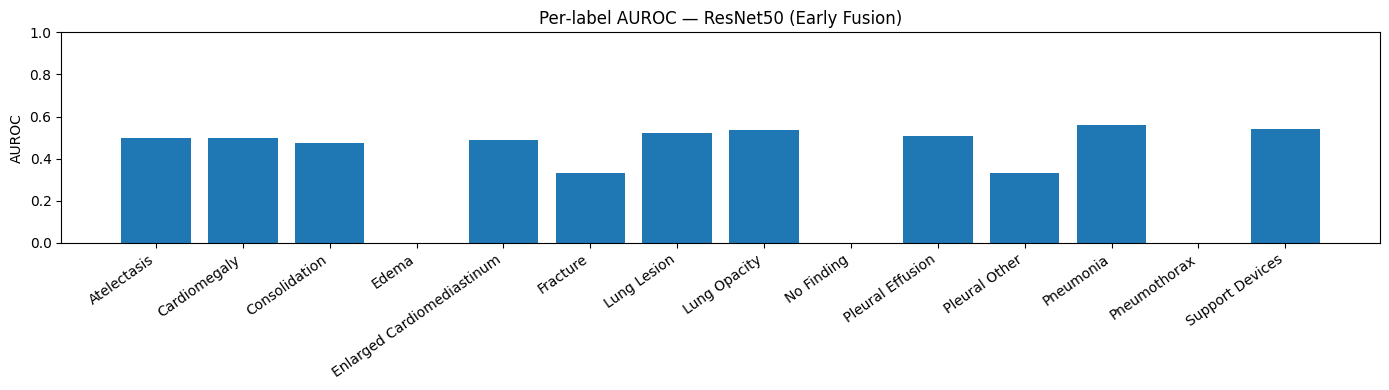


=== Evaluating Early Fusion — densenet121 ===


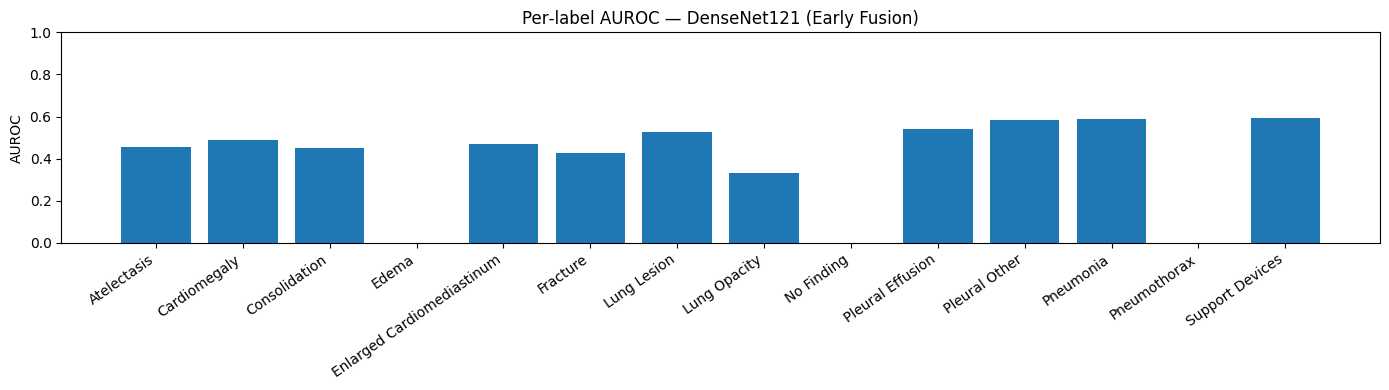


=== Evaluating Early Fusion — efficientnet_b2 ===


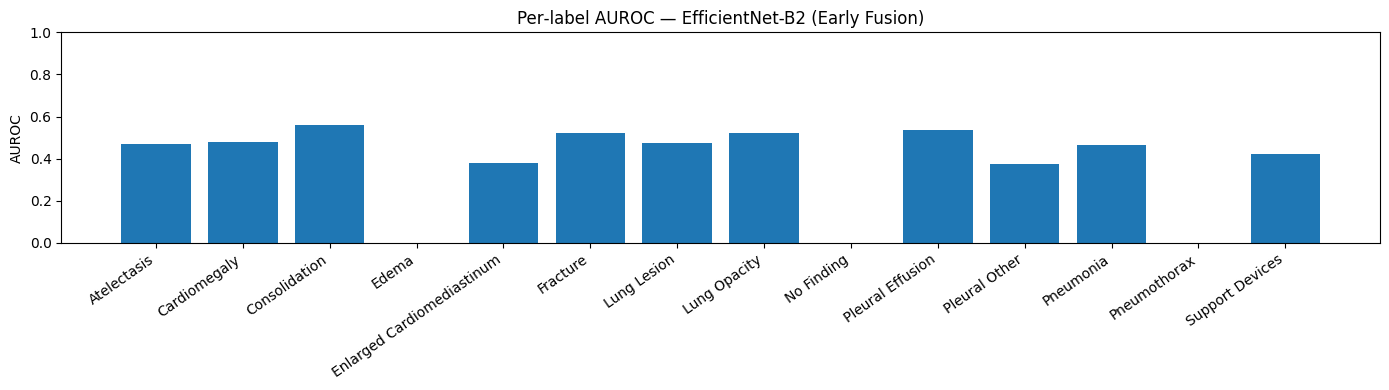


=== Evaluating Early Fusion — convnext_tiny ===


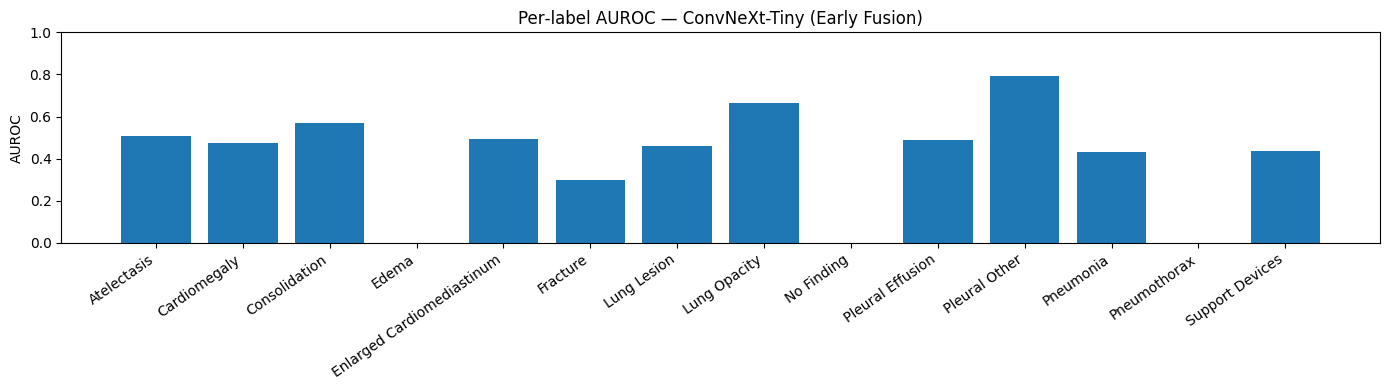


=== Evaluating Early Fusion — vgg16_bn ===


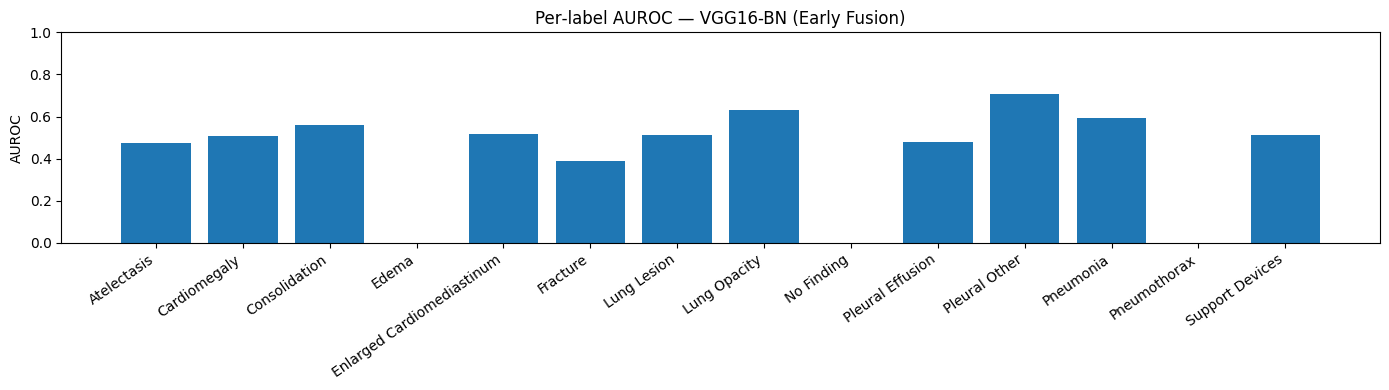


=== Early Fusion — Overall Summary ===
       backbone  macro_auroc  flat_auroc  macro_f1  flat_f1  eval_sec  eval_peak_gpu_GB                                        per_label_csv                                             per_label_plot
       ResNet50       0.4808      0.8244    0.7050   0.8428    1.6132            0.5768        checkpoints/eval_early/per_label_resnet50.csv        checkpoints/eval_early/per_label_auroc_resnet50.png
    DenseNet121       0.4965      0.7558    0.6392   0.7675    1.4955            0.4256     checkpoints/eval_early/per_label_densenet121.csv     checkpoints/eval_early/per_label_auroc_densenet121.png
EfficientNet-B2       0.4733      0.7241    0.6911   0.7984    1.1885            0.4459 checkpoints/eval_early/per_label_efficientnet_b2.csv checkpoints/eval_early/per_label_auroc_efficientnet_b2.png
  ConvNeXt-Tiny       0.5112      0.8208    0.7298   0.8459    1.6331            0.6583   checkpoints/eval_early/per_label_convnext_tiny.csv   checkpoints/eval_

In [ ]:
# === eval_early_fusion_multibackbone.py ===
import os, time
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_fscore_support

from dataloader import get_dataloaders
from healnet_early_fusion_multibackbone import EarlyFusionModel

# ---------------------------------------------------------------------
# Config
# ---------------------------------------------------------------------
SAVE_DIR   = Path("./checkpoints")
BACKBONES  = ["resnet50","densenet121","efficientnet_b2","convnext_tiny","vgg16_bn"]
LABELS = [
    "Atelectasis","Cardiomegaly","Consolidation","Edema","Enlarged Cardiomediastinum",
    "Fracture","Lung Lesion","Lung Opacity","No Finding","Pleural Effusion",
    "Pleural Other","Pneumonia","Pneumothorax","Support Devices"
]  # adjust if your dataset’s label order differs
THRESH = 0.5  # F1 threshold (global); can be changed to per-class array if I have tuned thresholds

# pretty names for plotting
PRETTY = {
    "resnet50":"ResNet50",
    "densenet121":"DenseNet121",
    "efficientnet_b2":"EfficientNet-B2",
    "convnext_tiny":"ConvNeXt-Tiny",
    "vgg16_bn":"VGG16-BN",
}

# ---------------------------------------------------------------------
# Metric helpers
# ---------------------------------------------------------------------
def masked_perclass_auroc(y_true, y_prob):
    """Per-class AUROC with CheXpert -1 masking; returns list[len=C] (np.nan where invalid)."""
    C = y_true.shape[1]
    out = []
    mask = (y_true != -1)
    for c in range(C):
        m = mask[:, c]
        if m.sum() == 0: out.append(np.nan); continue
        yt = y_true[m, c].astype(np.int32)
        yp = y_prob[m, c]
        if yt.max() == yt.min(): out.append(np.nan); continue
        out.append(roc_auc_score(yt, yp))
    return out

def masked_macro_flat_auroc(y_true, y_prob):
    # macro: mean of valid class AUROCs
    per = masked_perclass_auroc(y_true, y_prob)
    macro = float(np.nanmean(per)) if np.isfinite(per).any() else np.nan
    # flat/micro: pool all valid entries
    m = (y_true != -1)
    yt = y_true[m].astype(np.int32)
    yp = y_prob[m]
    flat = float(roc_auc_score(yt, yp)) if len(np.unique(yt)) > 1 else np.nan
    return macro, flat, per

def masked_perclass_f1(y_true, y_prob, thr=0.5):
    """Per-class F1 @ threshold with masking; returns list[len=C] (np.nan where invalid)."""
    C = y_true.shape[1]
    out = []
    m = (y_true != -1)
    # support scalar or per-class thresholds
    thr_vec = np.full(C, float(thr)) if np.isscalar(thr) else np.asarray(thr, dtype=float)
    for c in range(C):
        mm = m[:, c]
        if mm.sum() == 0: out.append(np.nan); continue
        yt = y_true[mm, c].astype(np.int32)
        yp = (y_prob[mm, c] >= thr_vec[c]).astype(np.int32)
        if len(np.unique(yt)) < 2: out.append(np.nan); continue
        out.append(f1_score(yt, yp))
    return out

def masked_macro_flat_f1(y_true, y_prob, thr=0.5):
    per = masked_perclass_f1(y_true, y_prob, thr=thr)
    macro = float(np.nanmean(per)) if np.isfinite(per).any() else np.nan
    m = (y_true != -1)
    yt = y_true[m].astype(np.int32)
    yp = (y_prob[m] >= (thr if np.isscalar(thr) else 0.5)).astype(np.int32)  # micro uses scalar thr
    flat = float(f1_score(yt, yp)) if len(np.unique(yt)) > 1 else np.nan
    return macro, flat, per

# ---------------------------------------------------------------------
# Evaluation routine (loads best checkpoint, times & measures VRAM)
# ---------------------------------------------------------------------
@torch.no_grad()
def evaluate_backbone(backbone: str, data_dir: str, lab_input_dim=100, batch_size=16, num_workers=4, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # dataloaders (reuse your split)
    _, _, test_loader = get_dataloaders(data_dir, batch_size=batch_size, num_workers=num_workers)

    # model + checkpoint
    model = EarlyFusionModel(num_classes=len(LABELS), lab_input_dim=lab_input_dim, cxr_backbone=backbone).to(device)
    ckpt = SAVE_DIR / f"early_fusion_{backbone}.pt"
    assert ckpt.exists(), f"Checkpoint not found: {ckpt}"
    state = torch.load(ckpt, map_location=device)
    model.load_state_dict(state)
    model.eval()

    # measure eval time + peak GPU
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    t0 = time.perf_counter()
    probs_all, targs_all = [], []
    for cxr, ecg, labs, y in test_loader:
        cxr  = cxr.to(device).float()
        labs = labs.to(device).float()
        y    = y.to(device)

        # ECG to (B,12,T)
        ecg = ecg.to(device).float()
        if ecg.ndim == 4 and ecg.shape[1] == 1:
            ecg = ecg.squeeze(1)
        if ecg.shape[1] != 12 and ecg.shape[-1] == 12:
            ecg = ecg.permute(0, 2, 1)

        logits = model(cxr, ecg, labs)
        probs_all.append(torch.sigmoid(logits).cpu().numpy())
        targs_all.append(y.cpu().numpy())

    eval_sec = time.perf_counter() - t0
    peak_gb  = (torch.cuda.max_memory_allocated() / 1e9) if torch.cuda.is_available() else 0.0

    y_prob = np.concatenate(probs_all, axis=0)
    y_true = np.concatenate(targs_all, axis=0)

    # metrics
    macro_auc, flat_auc, per_auc = masked_macro_flat_auroc(y_true, y_prob)
    macro_f1, flat_f1, per_f1    = masked_macro_flat_f1(y_true, y_prob, thr=THRESH)

    # per-label DataFrame
    df_labels = pd.DataFrame({
        "label": LABELS,
        "AUROC": per_auc,
        "F1": per_f1,
    })
    # Save per-backbone label metrics
    out_dir = SAVE_DIR / "eval_early"
    out_dir.mkdir(parents=True, exist_ok=True)
    csv_path = out_dir / f"per_label_{backbone}.csv"
    df_labels.to_csv(csv_path, index=False)

    # simple per-label AUROC bar plot
    plt.figure(figsize=(14, 4))
    x = np.arange(len(LABELS))
    plt.bar(x, np.nan_to_num(per_auc, nan=0.0))
    plt.xticks(x, LABELS, rotation=35, ha="right")
    plt.ylim(0, 1)
    plt.ylabel("AUROC")
    plt.title(f"Per‑label AUROC — {PRETTY.get(backbone, backbone)} (Early Fusion)")
    plt.tight_layout()
    fig_path = out_dir / f"per_label_auroc_{backbone}.png"
    plt.savefig(fig_path, dpi=220)
    plt.show()

    # return a compact summary row too
    row = {
        "backbone": PRETTY.get(backbone, backbone),
        "macro_auroc": macro_auc,
        "flat_auroc": flat_auc,
        "macro_f1": macro_f1,
        "flat_f1": flat_f1,
        "eval_sec": eval_sec,
        "eval_peak_gpu_GB": peak_gb,
        "per_label_csv": str(csv_path),
        "per_label_plot": str(fig_path),
    }
    return row, df_labels


# ---------------------------------------------------------------------
# Run evaluation for all backbones and build a bolded summary table
# ---------------------------------------------------------------------
def evaluate_all_backbones(data_dir: str, lab_input_dim=100, batch_size=16, num_workers=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    per_model_rows = []
    per_label_stack = []  # will collect (backbone, label, AUROC, F1)

    for b in BACKBONES:
        print(f"\n=== Evaluating Early Fusion — {b} ===")
        row, df_lab = evaluate_backbone(b, data_dir, lab_input_dim, batch_size, num_workers, device)
        per_model_rows.append(row)
        tmp = df_lab.copy()
        tmp["backbone"] = PRETTY.get(b, b)
        per_label_stack.append(tmp)

    # ------------------ overall summary (macro/flat + eval time/mem) ------------------
    df_summary = pd.DataFrame(per_model_rows)
    out_dir = SAVE_DIR / "eval_early"
    out_dir.mkdir(parents=True, exist_ok=True)
    sum_path = out_dir / "summary_overall.csv"
    df_summary.to_csv(sum_path, index=False)
    print("\n=== Early Fusion — Overall Summary ===")
    print(df_summary.round(4).to_string(index=False))
    print(f"\nSaved overall summary → {sum_path}")

    # ------------------ per-label × backbone tables (with bolded best) ------------------
    per_label_df = pd.concat(per_label_stack, ignore_index=True)
    # Pivot for AUROC and F1
    auc_tbl = per_label_df.pivot(index="label", columns="backbone", values="AUROC")
    f1_tbl  = per_label_df.pivot(index="label", columns="backbone", values="F1")

    # Bold the column-wise max values (best backbone per label)
    def bold_max(s):
        # if all nan, return as-is
        if np.all(np.isnan(s.values)): 
            return ['' for _ in s]
        m = s.max(skipna=True)
        return [f"font-weight: bold" if (pd.notna(v) and np.isclose(v, m)) else "" for v in s]

    auc_styled = auc_tbl.style.format("{:.3f}").apply(bold_max, axis=1)
    f1_styled  = f1_tbl.style.format("{:.3f}").apply(bold_max, axis=1)

    # Save CSV & (optional) LaTeX with bolding via \textbf{}
    auc_csv = out_dir / "per_label_AUROC.csv"
    f1_csv  = out_dir / "per_label_F1.csv"
    auc_tbl.to_csv(auc_csv)
    f1_tbl.to_csv(f1_csv)

    try:
        # Convert bold style to LaTeX by replacing max with \textbf{} (manual pass)
        # We'll build LaTeX ourselves to guarantee bold.
        def to_latex_bold(df):
            lines = ["\\begin{tabular}{l" + "r"*df.shape[1] + "}", "\\toprule"]
            header = ["Label"] + list(df.columns)
            lines.append(" & ".join(header) + " \\\\")
            lines.append("\\midrule")
            for idx, row in df.iterrows():
                vals = []
                m = np.nanmax(row.values.astype(float)) if np.isfinite(row.values).any() else np.nan
                for v in row.values:
                    if pd.isna(v):
                        vals.append("")
                    elif np.isclose(v, m):
                        vals.append(f"\\textbf{{{v:.3f}}}")
                    else:
                        vals.append(f"{v:.3f}")
                lines.append(" & ".join([idx] + vals) + " \\\\")
            lines.append("\\bottomrule\n\\end{tabular}")
            return "\n".join(lines)

        with open(out_dir/"per_label_AUROC.tex","w") as f:
            f.write(to_latex_bold(auc_tbl))
        with open(out_dir/"per_label_F1.tex","w") as f:
            f.write(to_latex_bold(f1_tbl))
        print("Saved LaTeX tables with bold maxima.")
    except Exception as e:
        print(f"LaTeX export skipped: {e}")

    # Also save styled HTML (handy for Jupyter preview)
    try:
        auc_styled.to_html(out_dir/"per_label_AUROC.html")
        f1_styled.to_html(out_dir/"per_label_F1.html")
    except Exception as e:
        print(f"HTML export skipped: {e}")

    return df_summary, auc_tbl, f1_tbl

# ---------------------------------------------------------------------
# Entry: call evaluate_all_backbones with your DATA DIR
# ---------------------------------------------------------------------
# Example:
df_summary, auc_tbl, f1_tbl = evaluate_all_backbones(
    data_dir="/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/data/processed_pt_correctedV2",
    lab_input_dim=100,
    batch_size=16,
    num_workers=4
)


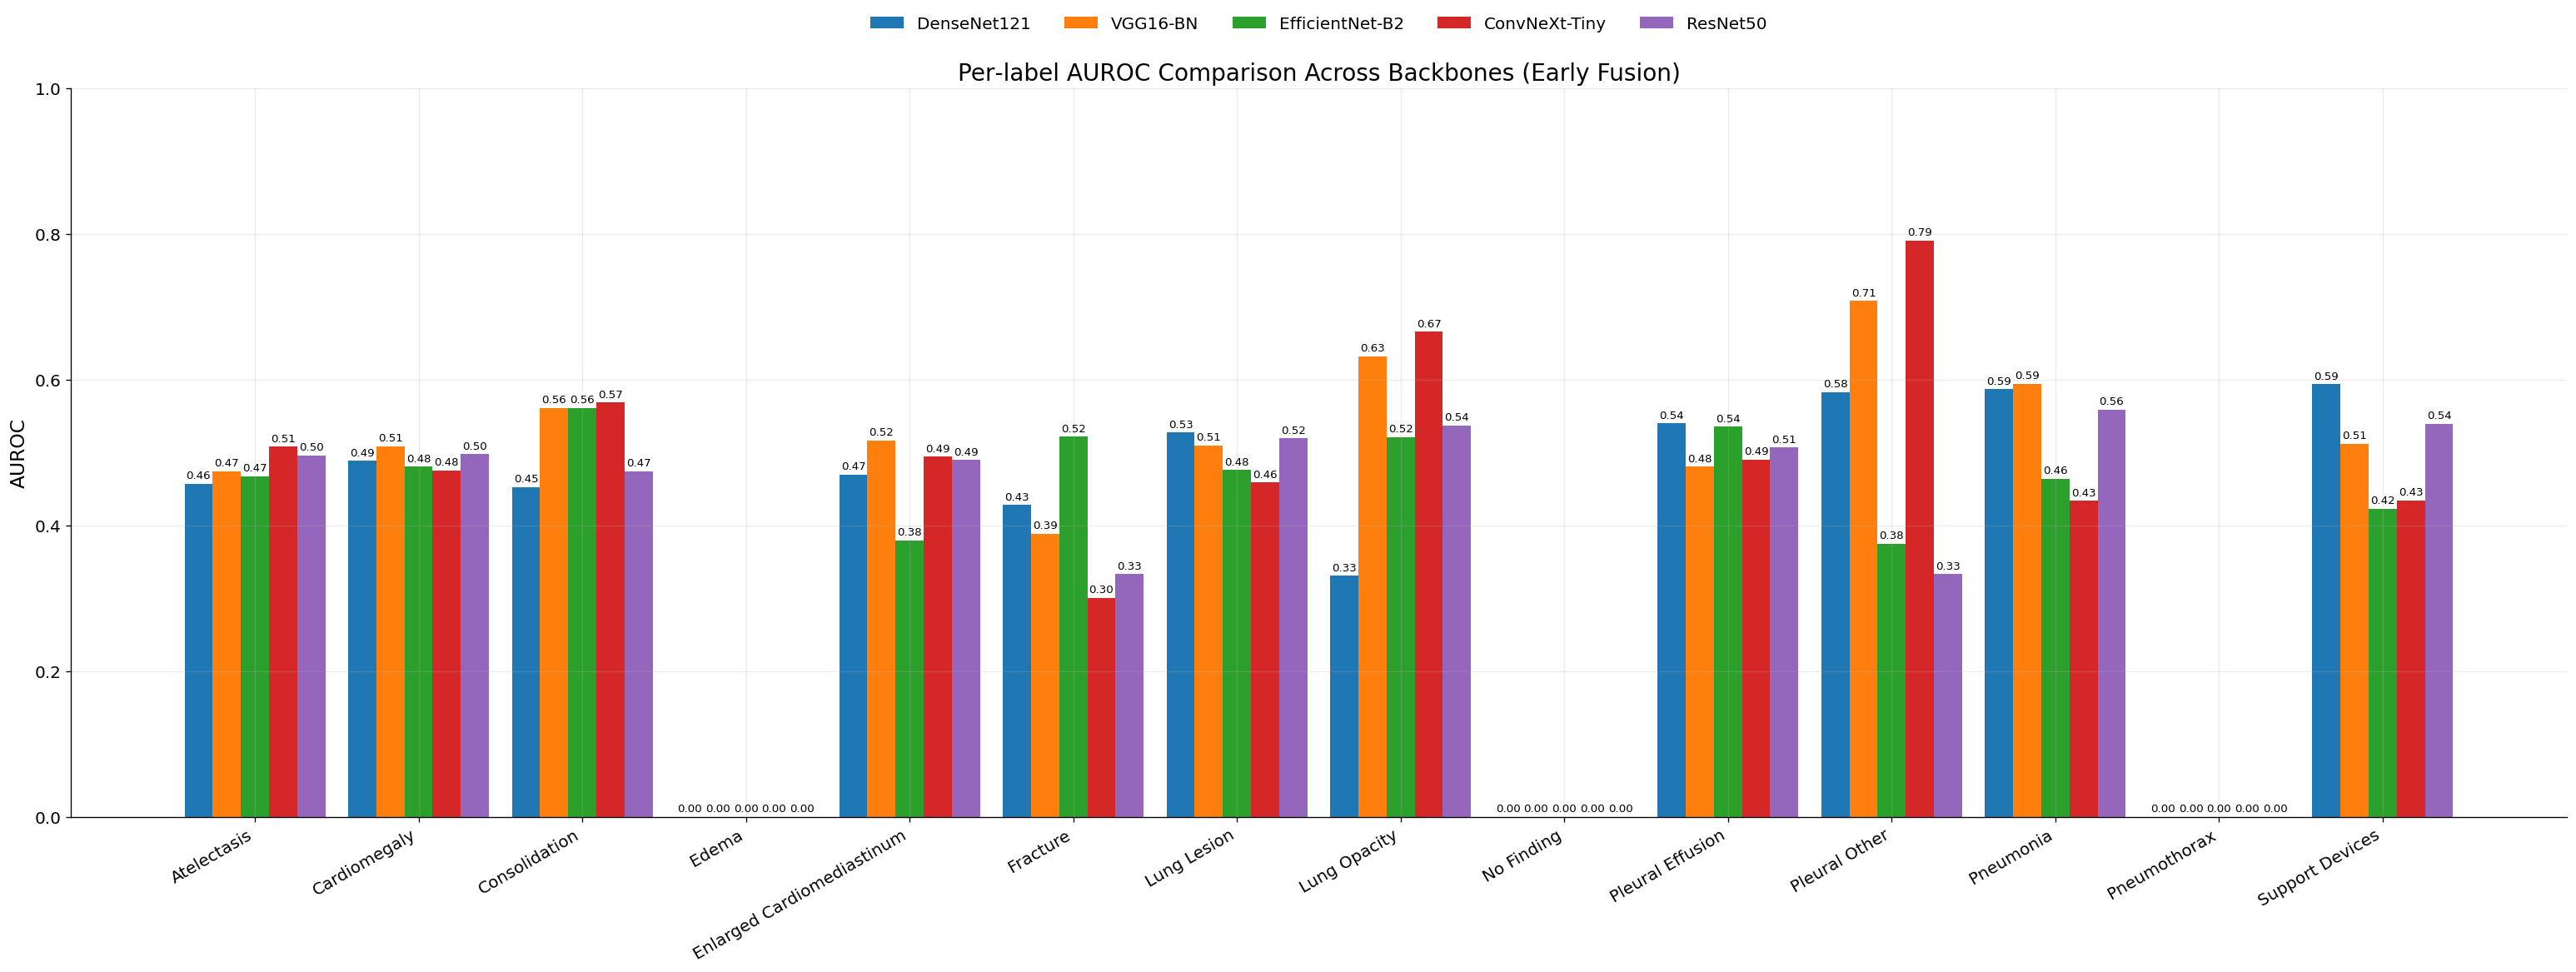

Saved: checkpoints/eval_early/per_label_auroc_comparison_across_backbones_early.png


In [ ]:
# === Plot: Per-label AUROC comparison across backbones (Early Fusion) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

SAVE_DIR  = Path("./checkpoints/eval_early")  
BACKBONES = ["densenet121", "vgg16_bn", "efficientnet_b2", "convnext_tiny", "resnet50"]
PRETTY    = {
    "resnet50":"ResNet50",
    "densenet121":"DenseNet121",
    "efficientnet_b2":"EfficientNet-B2",
    "convnext_tiny":"ConvNeXt-Tiny",
    "vgg16_bn":"VGG16-BN",
}

# If we want to enforce a specific label order, set LABELS; otherwise, it takes labels from the first CSV.
LABELS = None  # e.g., ["Atelectasis","Cardiomegaly", ...]  # or leave None

def read_per_label(backbone):
    csv = SAVE_DIR / f"per_label_{backbone}.csv"
    df = pd.read_csv(csv)
    if "label" not in df.columns or "AUROC" not in df.columns:
        raise ValueError(f"{csv} must have columns: label, AUROC")
    return df[["label","AUROC"]]

# --- Load and align all backbones ---
dfs = {b: read_per_label(b) for b in BACKBONES}
if LABELS is None:
    LABELS = dfs[BACKBONES[0]]["label"].tolist()

# Build a matrix: rows=labels, cols=backbones
mat = np.zeros((len(LABELS), len(BACKBONES)), dtype=float)
mat[:] = np.nan
for j, b in enumerate(BACKBONES):
    dd = dfs[b].set_index("label")["AUROC"]
    for i, lab in enumerate(LABELS):
        if lab in dd:
            mat[i, j] = dd[lab]

# --- Plot ---
# --- Plot (larger, clearer) ---
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.grid": True, "grid.alpha": 0.25,
    "axes.spines.top": False, "axes.spines.right": False,
    "font.size": 14,         # bigger base font
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

fig, ax = plt.subplots(figsize=(26, 10))   # <--- wider and taller



n_labels = len(LABELS)
n_bb = len(BACKBONES)
x = np.arange(n_labels)
group_width = 0.86
bar_w = group_width / n_bb
offsets = (np.arange(n_bb) - (n_bb-1)/2) * bar_w

# fig, ax = plt.subplots(figsize=(18, 6))

bars = []
for j, b in enumerate(BACKBONES):
    vals = np.nan_to_num(mat[:, j], nan=0.0)
    bc = ax.bar(x + offsets[j], vals, width=bar_w, label=PRETTY.get(b, b))
    bars.append(bc)

# annotate value on top of each bar
def annotate_barcontainer(bc, fmt="{:.2f}"):
    for rect in bc:
        h = rect.get_height()
        if np.isnan(h): 
            continue
        ax.annotate(fmt.format(h),
                    xy=(rect.get_x() + rect.get_width()/2, h),
                    xytext=(0, 2), textcoords="offset points",
                    ha="center", va="bottom", fontsize=8, rotation=0)

for bc in bars:
    annotate_barcontainer(bc, fmt="{:.2f}")

ax.set_ylim(0, 1.0)
ax.set_ylabel("AUROC")
ax.set_title("Per‑label AUROC Comparison Across Backbones (Early Fusion)")

ax.set_xticks(x)
ax.set_xticklabels(LABELS, rotation=30, ha="right")

# place legend above the plot
ax.legend(ncols=min(5, n_bb), loc="upper center", bbox_to_anchor=(0.5, 1.12), frameon=False)

fig.tight_layout()
out_path = SAVE_DIR / "per_label_auroc_comparison_across_backbones_early.png"
fig.savefig(out_path, dpi=220, bbox_inches="tight")
plt.show()
print(f"Saved: {out_path}")
